In [1]:
# setup
from mlwpy import *
%matplotlib inline

In [2]:
diabetes = datasets.load_diabetes()

tts = skms.train_test_split(diabetes.data,
                            diabetes.target,
                            test_size=.25,
                            random_state=42)

(diabetes_train_ftrs, diabetes_test_ftrs, diabetes_train_tgt, diabetes_test_tgt) = tts

#  Baseline Regressors
We’ve already been exposed to predicting the **middle** value, we can easily create baseline models that predict the **mean** and the **median**, We can also pick arbitrary **constant** <br>
A last option, `quantile`, To get the n% point of the data( median is 50% point)

In [3]:
strategies = ['constant', 'quantile', 'mean', 'median']
baseline_args = [{"strategy":s} for s in strategies]

# additional args for constant and quantile
baseline_args[0]['constant'] = 50.0  # baseline_args[0] = {'strategy': 'constant', 'constant': 50.0}
baseline_args[1]['quantile'] = 0.75  # baseline_args[1] = {'strategy': 'quantile', 'quantile': 0.75}

# process a single argument package (a dict)
def do_one(**args):
    baseline = dummy.DummyRegressor(**args)
    baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
    base_preds = baseline.predict(diabetes_test_ftrs)
    return metrics.mean_squared_error(base_preds, diabetes_test_tgt)

# gather all results via a list comprehension
mses = [do_one(**bla) for bla in baseline_args]

display(pd.DataFrame({'mse':mses}, index=strategies))

,mse
constant,"14,657.6847"
quantile,"10,216.3874"
mean,"5,607.1979"
median,"5,542.2252"


# Additional Measures for Regression
So far, we’ve used mean squared error as our measure of success—or perhaps more accurately, a measure of failure—in regression problems. We also modified MSE to the root mean squared error (RMSE) because the scale of MSE is a bit off compared to our
predictions

##  Creating Our Own Evaluation Metric 
Generally, sklearn wants to work with scores, where bigger is better.So we’ll develop our new regression evaluation metric in three steps.
1. We’ll define an error measure
2. use the error to define a score, 
3. use the score to create a scorer

Once we’ve defined the scorer function, we can simply pass the scorer with a scoring parameter to `cross_val_score`.

In [4]:
def rms_error(actual, predicted):
    ' root-mean-squared-error function '
    # lesser values are better (a < b means a is better)
    mse = metrics.mean_squared_error(actual, predicted)
    return np.sqrt(mse)

def neg_rmse_score(actual, predicted):
    ' rmse based score function '
    # greater values are better (a < b means b better)
    return -rms_error(actual, predicted)

def neg_rmse_scorer(mod, ftrs, tgt_actual):
    ' rmse scorer suitable for scoring arg '
    tgt_pred = mod.predict(ftrs)
    return neg_rmse_score(tgt_actual, tgt_pred)

knn = neighbors.KNeighborsRegressor(n_neighbors=3)
skms.cross_val_score(knn, diabetes.data, diabetes.target,
                    cv=skms.KFold(5, shuffle=True),
                    scoring=neg_rmse_scorer)

array([-58.0034, -64.9886, -63.1431, -61.8124, -57.6243])

Remember that we are measuring scores not errors so we want the values to be high (closer to zero)

## Other Built-in Regression Metrics

In [5]:
lr = linear_model.LinearRegression()

# help(lr.score) # for full output
print(lr.score.__doc__)

Return the coefficient of determination :math:`R^2` of the
        prediction.

        The coefficient :math:`R^2` is defined as :math:`(1 - \frac{u}{v})`,
        where :math:`u` is the residual sum of squares ``((y_true - y_pred)
        ** 2).sum()`` and :math:`v` is the total sum of squares ``((y_true -
        y_true.mean()) ** 2).sum()``. The best possible score is 1.0 and it
        can be negative (because the model can be arbitrarily worse). A
        constant model that always predicts the expected value of `y`,
        disregarding the input features, would get a :math:`R^2` score of
        0.0.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test samples. For some estimators this may be a precomputed
            kernel matrix or a list of generic objects instead with shape
            ``(n_samples, n_samples_fitted)``, where ``n_samples_fitted``
            is the number of samples used in the fitting for the esti

So from the above we can see that R$^2$ = 1 - $\frac{\sum_{i=1}^{n} (actual - prediction)^2}{\sum_{i=1}^{n} (actual mean - prediction)^2}$

The default metric for linear regression is `R2`. In fact, `R2` is the default metric for all
regressors. We’ll have more to say about R2 in a few minutes. The other major built-in
performance evaluation metrics for regressors are `mean absolute error`, mean squared error
(which we’ve been using), and `median absolute error`.

#### MAE vs MSE
The difference between them that MSE gives larger penalties to larger errors<br>
The difference beween an error of 2 and 4: in **MAE** goes from 2 to 4 but in **MSE** goes from 4 to 16
`median absolute error` can be used to to protect us from single large errors overwhelming other well-behaved errors

## R$^2$

In [6]:
our_preds = np.array([1, 2, 3])
mean_preds = np.array([2, 2, 2])
actual = np.array([2, 3, 4])

sse_ours = np.sum(( our_preds - actual)**2)
sse_mean = np.sum((mean_preds - actual)**2)
r_2 = 1 - (sse_ours / sse_mean)
print("manual r2:{:5.2f}".format(r_2))   

manual r2: 0.40


What is the ratio $\frac{SSE_{ours}}{SSE_{mean}}$ means, well it's the ratio between our predictor error to the baseline predictor (which always predict the mean) So we are normalizing our result so if the baseline model has error of 10000 and our predictor has error of 2500 Then R2 = 1- 0.25 = 0.75 **But do we need the -1?**

###  An Interpretation of R2 for the Machine Learning World

The term $\frac{SSE_{ours}}{SSE_{mean}}$ will be between 0 and 1, if the linear regression makes no errors on the
data, it will be zero and if the linear regression uses only a constant term, it will be identical to the mean
and the value will be 1

* `R2 = 1` means that our model has no error 
* `R2 = 0` means that our model predict the same way as our baseline model(mean value) 
* `R2 = -ve` means that our model is worse than the baseline and produce larger error which makes the fraction > 1 

### A Cold Dose of Reality: sklearn’s R2

In [7]:
baseline = dummy.DummyRegressor(strategy='mean')

baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
base_preds = baseline.predict(diabetes_test_ftrs)

# r2 is not symmetric because true values have priority
# and are used to compute target mean
base_r2_sklearn = metrics.r2_score(diabetes_test_tgt, base_preds)
print(base_r2_sklearn)

-0.014016723490579253


Now, let’s look at those values with some manual computations:

In [8]:
# sklearn-train-mean to predict test tgts
base_errors = base_preds - diabetes_test_tgt
sse_base_preds = np.dot(base_errors, base_errors) # SSE ours

# train-mean to predict test targets
train_mean_errors = np.mean(diabetes_train_tgt) - diabetes_test_tgt
sse_mean_train = np.dot(train_mean_errors, train_mean_errors) 

# test-mean to predict test targets (Danger Will Robinson!)
test_mean_errors = np.mean(diabetes_test_tgt) - diabetes_test_tgt
sse_mean_test = np.dot(test_mean_errors, test_mean_errors) # SSE mean

print("sklearn train-mean model SSE(on test):", sse_base_preds)
print(" manual train-mean model SSE(on test):", sse_mean_train)
print(" manual test-mean model SSE(on test):", sse_mean_test)

sklearn train-mean model SSE(on test): 622398.9703179051
 manual train-mean model SSE(on test): 622398.9703179051
 manual test-mean model SSE(on test): 613795.5675675676


In [9]:
1 - (sse_base_preds / sse_mean_test)

-0.014016723490578809

sklearn’s R2 is specifically calculating its base model—the mean model—from the true values we are testing against. We are not comparing the performance of `my_model.fit(train)` and `mean_model.fit(train)`. With sklearn’s R2, we are comparing
`my_model.fit(train)` with `mean_model.fit(test)` and evaluating them against test.

## Residual Plots

## 1. Error Plots
To get started, let’s graph an actual, true target value against a predicted value. The
graphical distance between the two represents our error

In [10]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
'actual' : [3, 5, 7]})

ape_df['error'] = ape_df['predicted'] - ape_df['actual']

ape_df.index.name = 'example'
display(ape_df)

,predicted,actual,error
example,,,
0,4,3,1
1,2,5,-3
2,9,7,2


In [11]:
list(it.permutations(['actual', 'predicted']))

[('actual', 'predicted'), ('predicted', 'actual')]

In [12]:
def regression_errors(figsize, predicted, actual, errors='all'):
    ''' figsize -> subplots;
    predicted/actual data -> columns in a DataFrame
    errors -> "all" or sequence of indices '''
    
    # Create 1*2 subplots with the figsize inputed, Build a dataframe with the predicted, actual
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True) 
    df = pd.DataFrame({'actual':actual,'predicted':predicted})

    # fist iter --> 0, ('actual', 'predicted')
    # second iter --> 1, ('predicted', 'actual')
    for ax, (x,y) in zip(axes, it.permutations(['actual', 'predicted'])): 
        
        # plot the data as '.'; perfect as y=x line
        ax.plot(df[x], df[y], '.', label='data')
        ax.plot(df['actual'], df['actual'], '-', label='perfection')  # y=x for the actual data
        ax.legend()

        ax.set_xlabel('{} Value'.format(x.capitalize()))
        ax.set_ylabel('{} Value'.format(y.capitalize()))
        ax.set_aspect('equal')
    
    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position("right")

    # show connecting bars from data to perfect
    # for all or only those specified?
    if errors == 'all':
        errors = range(len(df))
    if errors:
        acts = df.actual.iloc[errors]  # determine the error points for the actual data
        preds = df.predicted.iloc[errors]  # determine the error points for the predicted data
        axes[0].vlines(acts, preds, acts, 'r') # draw vertical line between two points
        axes[1].hlines(acts, preds, acts, 'r') # draw horizontal line between two points

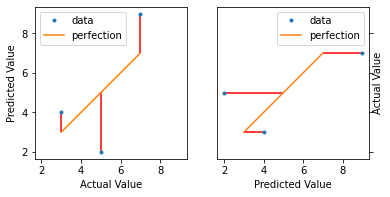

In [13]:
regression_errors((6, 3), ape_df.predicted, ape_df.actual)

In both cases, the orange line (y = x which in this case is predicted = actual) is conceptually an omniscient model where the predicted value is the true actual value.

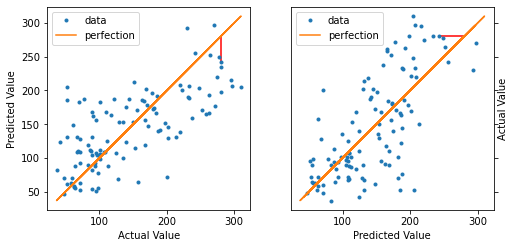

In [14]:
lr = linear_model.LinearRegression()
preds = (lr.fit(diabetes_train_ftrs, diabetes_train_tgt).predict(diabetes_test_ftrs))

regression_errors((8, 4), preds, diabetes_test_tgt, errors=[-20]) 

The two graphs asks different questions
1. left: Compared to reality (Actual Value), how did we do?
2. right : For a given prediction (Predicted Value), how do we do?

The difference is similar to percision-recall relationship, Let's say that we are predicting sick we can see that when the actual value is from 200 - 250 the prediction is lower than the actual (under the y=x line), When the predicted value is near 200, we have real values ranging from 50 to 300 (data points are across the plot)

## 2.  Residual Plots
We talked about the error of our predictions:
error = predicted − actual. But for residual plots, we need the mirror image of these:
residuals = actual − predicted.

In [15]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
'actual' : [3, 5, 7]})

ape_df['error'] = ape_df['predicted'] - ape_df['actual']
ape_df['resid'] = ape_df['actual'] - ape_df['predicted']
display(ape_df)

,predicted,actual,error,resid
0,4,3,1,-1
1,2,5,-3,3
2,9,7,2,-2


Error of 2 means that we are over the real point by 2, error of -2 means we are under<br>

Residual plots are made by graphing the predicted value against the residual for that prediction

For example, we predict 31.5 for an example that is actually 27.5. The residual is −4.0. So, we’ll have a point at (x = predicted = 31.5, y = residual = −4.0). Incidentally, these can be thought of as what’s left over after we make a prediction. If it's +ve means we need to add more to get the actual point 

In [16]:
def regression_residuals(ax, predicted, actual, show_errors=None, right=False):
    ''' figsize -> subplots;
    predicted/actual data -> columns of a DataFrame
    errors -> "all" or sequence of indices '''
    
    df = pd.DataFrame({'actual':actual, 'predicted':predicted})
    df['resid'] = df.actual - df.predicted
    ax.plot(df.predicted, df.resid, '.')
    ax.plot(df.predicted, np.zeros_like(predicted), '-')

    if right:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.set_xlabel('Predicted Value')
    ax.set_ylabel('Residual')

    if show_errors == 'all':
        show_errors = range(len(df))
    if show_errors:
        preds = df.predicted.iloc[show_errors] # get predicted val for error points
        errors = df.resid.iloc[show_errors]  # get residual val for error points
        ax.vlines(preds, 0, errors, 'r')  # drae vertical line between them
        
        

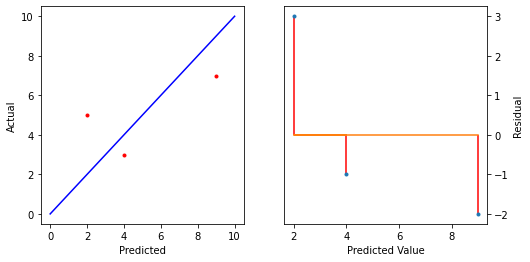

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.plot(ape_df.predicted, ape_df.actual, 'r.', [0, 10], [0, 10], 'b-') # perfect line Pred vs actul
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
regression_residuals(ax2, ape_df.predicted, ape_df.actual, 'all', right=True)

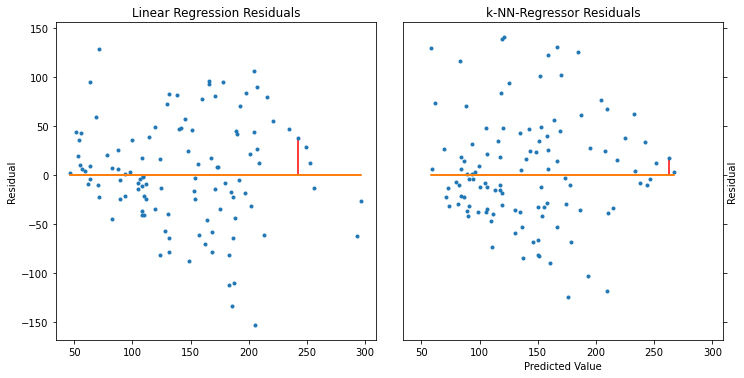

In [18]:
lr = linear_model.LinearRegression()
knn = neighbors.KNeighborsRegressor()

models = [lr, knn]

fig, axes = plt.subplots(1, 2, figsize=(10, 5),sharex=True, sharey=True)
fig.tight_layout()

for model, ax, on_right in zip(models, axes, [False, True]):
    preds = (model.fit(diabetes_train_ftrs, diabetes_train_tgt).predict(diabetes_test_ftrs))

    regression_residuals(ax, preds, diabetes_test_tgt, [-20], on_right)

axes[0].set_title('Linear Regression Residuals')
axes[1].set_title('k-NN-Regressor Residuals');

With the linear regression model, the value is predicted a hint under 250. With the k-NN-R model, the
value is predicted to be a bit above 250. In both cases, it is underpredicted (remember,
residuals tell us how to fix up the prediction: we need to add a bit to these predictions).
The actual value is:

In [19]:
print(diabetes_test_tgt[-20])

280.0


If either of our models predicted 280, the residual would be zero.

# A First Look at Standardization
normalization is the process of taking different measurements
and putting them on a directly comparable footing. Often, this involves two steps:
1. adjusting the center of the data
2. adjusting the scale of the data

When we standardize our data, we do two things: 
1. we center the data around zero and 
2. we scale the data so it has a standard deviation of 1

Those two steps happen by (1) subtracting the mean and then (2) dividing by the standard deviation

,x,std-ized
mean,2.5000,0.0000
std,4.6706,1.0000


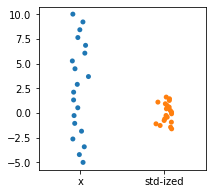

In [20]:
# 1D standardization
# place evenly spaced values in a dataframe
xs = np.linspace(-5, 10, 20)
df = pd.DataFrame(xs, columns=['x'])

# center ( - mean) and scale (/ std)
df['std-ized'] = (df.x - df.x.mean()) / df.x.std()

# show original and new data; compute statistics
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.stripplot(data=df)
display(df.describe().loc[['mean', 'std']])

In [21]:
# 2 1D standardizations
xs = np.linspace(-5, 10, 20)
ys = 3*xs + 2 + np.random.uniform(20, 40, 20)

df = pd.DataFrame({'x':xs, 'y':ys})
df_std_ized = (df - df.mean()) / df.std()

display(df_std_ized.describe().loc[['mean', 'std']])

,x,y
mean,0.0000,-0.0000
std,1.0000,1.0000


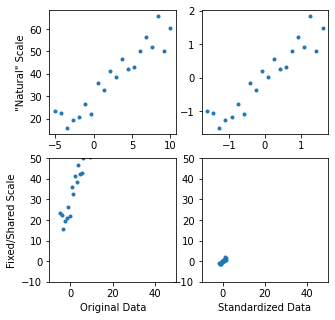

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

ax[0,0].plot(df.x, df.y, '.')    # plot actual points fig1
ax[0,1].plot(df_std_ized.x, df_std_ized.y, '.')  # plot standarized points fig2
ax[0,0].set_ylabel('Natural" Scale')

ax[1,0].plot(df.x, df.y, '.')
ax[1,1].plot(df_std_ized.x, df_std_ized.y, '.')

ax[1,0].axis([-10, 50, -10, 50])
ax[1,1].axis([-10, 50, -10, 50])

ax[1,0].set_ylabel('Fixed/Shared Scale')
ax[1,0].set_xlabel('Original Data')
ax[1,1].set_xlabel('Standardized Data');

We can see that the shape of the data stays the same after standarization however the data now has mean of 0 and std of 1

We can perform standardization in sklearn using a special “learner” named `StandardScaler`.<br>
This **Learner** is different than the other learner we've seen (knn, linear regression,...), the learner figures out the
mean and standard deviation from the training data and applies these values to transform the data ***Transform works the same way as predict***

In [26]:
train_xs, test_xs = skms.train_test_split(xs.reshape(-1, 1), test_size=.5)

scaler = skpre.StandardScaler()
scaler.fit(train_xs).transform(test_xs)

array([[-1.3427],
       [-0.4593],
       [ 0.424 ],
       [ 0.0707],
       [ 1.8373],
       [-0.8127],
       [-0.2827],
       [ 0.954 ],
       [ 1.1307],
       [ 1.6607]])

In [27]:
# We will use a pipeline for these steps

(train_xs, test_xs, train_ys, test_ys)= skms.train_test_split(xs.reshape(-1, 1), ys.reshape(-1, 1), test_size=.5)

scaler = skpre.StandardScaler()
lr = linear_model.LinearRegression()

std_lr_pipe = pipeline.make_pipeline(scaler, lr) # Create our pipeline with the two steps

std_lr_pipe.fit(train_xs, train_ys).predict(test_xs)

array([[42.7723],
       [60.4456],
       [15.    ],
       [25.099 ],
       [30.1485],
       [12.4752],
       [27.6238],
       [35.198 ],
       [37.7228],
       [55.396 ]])

The pipeline itself acts just like any other **learner** we’ve seen: it has `fit` and `predict` methods. We can use a pipeline as a plug-in substitute for any other learning method.<br>
A detail on pipelines: even though the `StandardScaler` uses `transform` when it is applied stand-alone, the overall `pipeline` uses `predict` to apply the transformation<br>
Finally one last warning, Just like we don’t want to peek with a full-blown learner we don't want to peek with our preprocessing (like : standardScaler)
